# VAE for encoding Trajectories

Creates a (n/4) latent vectors of size 6 to represent a trajectory with n points. Notebook evaluates the model

In [22]:
import time

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from quadrotor_diffusion.utils.trajectory import (
    derive_trajectory,
)

from quadrotor_diffusion.utils.dataset.dataset import QuadrotorTrajectoryDataset, evaluate_dataset
from quadrotor_diffusion.utils.file import get_checkpoint_file
from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.vae import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs

In [23]:
model: VAE_Wrapper = None
ema: VAE_Wrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", 42)
eval, _, normalizer, trainer_args = Trainer.load(chkpt)
data = QuadrotorTrajectoryDataset("../data/quadrotor_random", normalizer, order=0)
print(chkpt)

../logs/training/42.VAE_Wrapper.Nov.22_04:31_PM/checkpoints/epoch_24_loss_0.0001


In [24]:
eval = eval.to('cuda')

sample = data[126]
ref_pos = normalizer.undo(sample)

def decoder(mu, padding):
    model_out = eval.decode(mu).squeeze(0).cpu().numpy()
    model_out = model_out[padding:-padding, :]
    reconstructed = normalizer.undo(model_out)
    return reconstructed


inp = torch.tensor(sample).float().unsqueeze(0).cuda()
start = time.time()
mu, logvar = eval.encode(inp, padding=32)
encode = time.time()
reconstructed = eval.decode(mu, padding=32).squeeze(0).cpu().numpy()
encode_time = encode - start
decode_time = time.time() - encode

print(f"Encoded in {encode_time:.1e}, decoded in {decode_time:.1e}")

Encoded in 5.1e-03, decoded in 4.4e-03


/tmp/ipykernel_1148406/905464550.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float().unsqueeze(0).cuda()


### Visualizing reconstructed result on a random sample

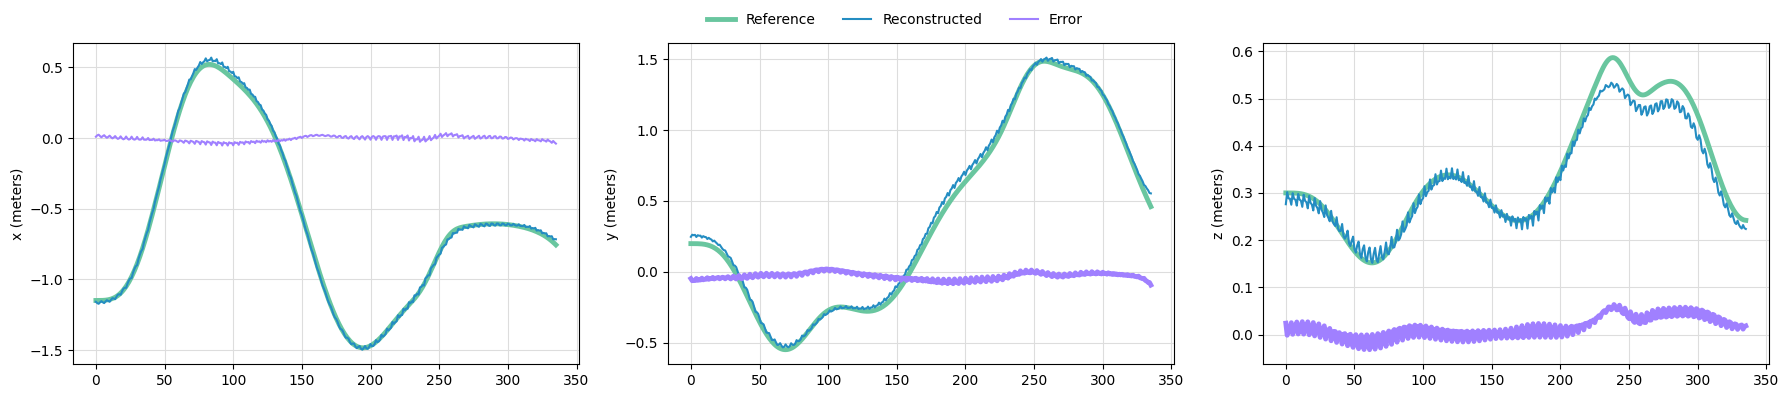

In [25]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(ref_pos[:, 0], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 0] - reconstructed[:, 0], label='Error', linewidth=1.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(ref_pos[:, 1], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 1] - reconstructed[:, 1], label='Error', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(ref_pos[:, 2], label='Reference', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reconstructed', linewidth=1.5)
plt.plot(ref_pos[:, 2] - reconstructed[:, 2], label='Error', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', 'Reconstructed', 'Error'], loc='upper center', ncol=3, frameon=False)
plt.show()

### Interpolation between two samples
Adjust `beta0` and `beta1` for weighted interpolation

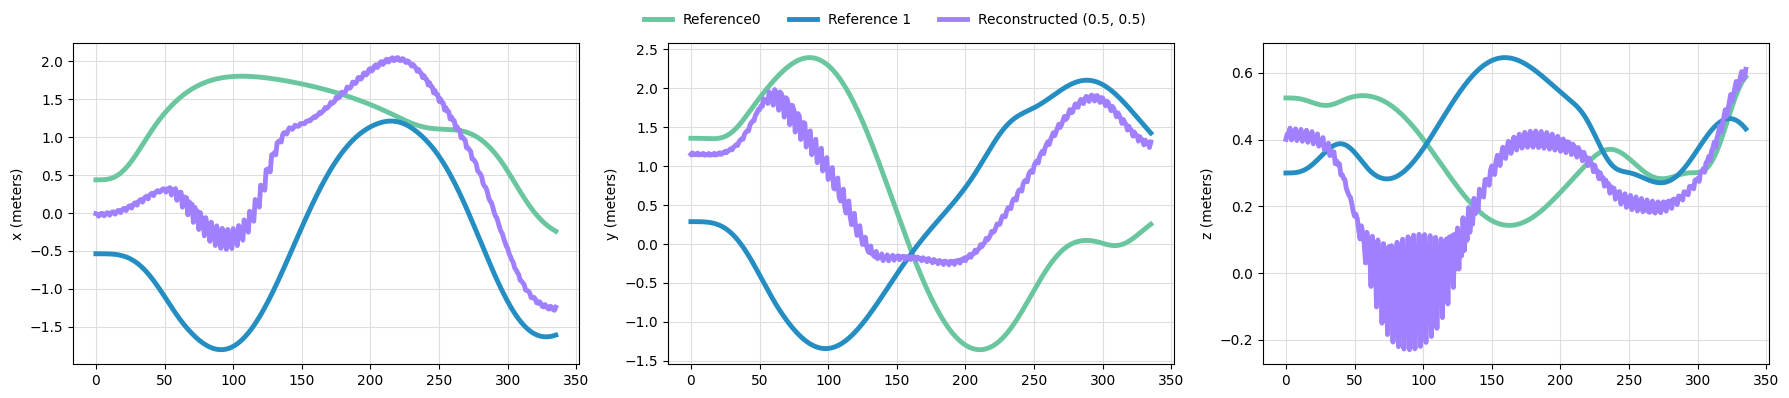

In [26]:
sample0 = data[16]
sample1 = data[17]

reference0 = normalizer.undo(sample0).numpy()
reference1 = normalizer.undo(sample1).numpy()

mu1, _ = eval.encode(sample0.unsqueeze(0).cuda(), padding=32)
mu2, _ = eval.encode(sample1.unsqueeze(0).cuda(), padding=32)

beta0 = 0.5
beta1 = 0.5
mu = beta0 * mu1 + beta1 * mu2
reconstructed = eval.decode(mu, padding=32).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 0], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 1], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reference1[:, 2], label='Reference 1', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference0', "Reference 1", f'Reconstructed ({beta0}, {beta1})'], loc='upper center', ncol=3, frameon=False)
plt.show()


### Testing adding noise to latent trajectory

tensor(0.3995, device='cuda:0')


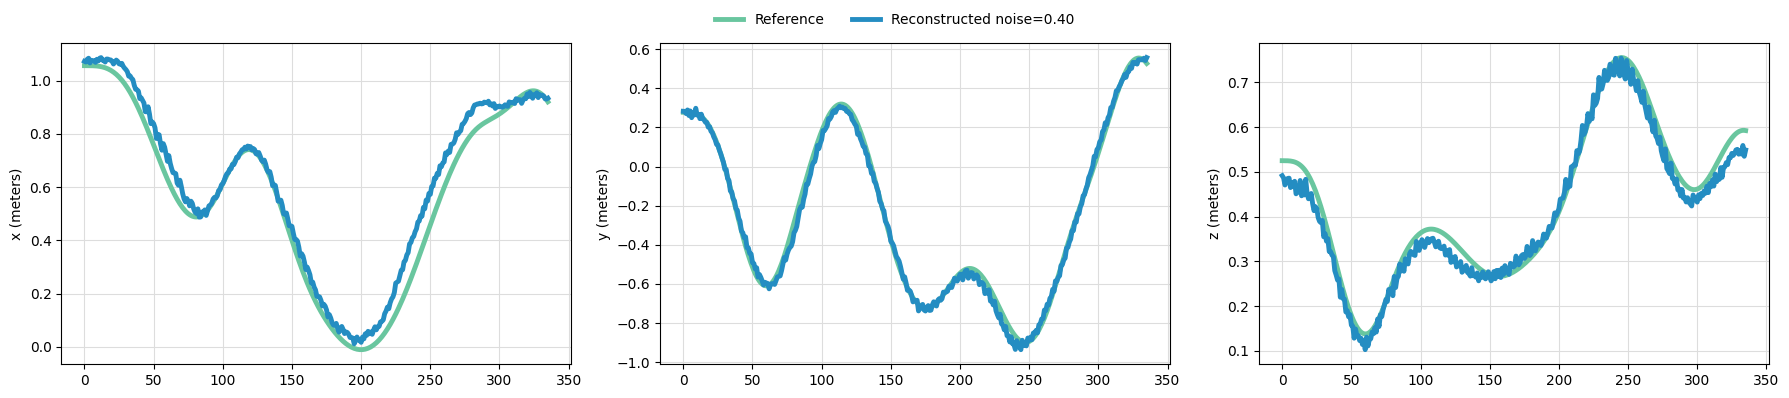

In [27]:
sample0 = data[136]

reference0 = normalizer.undo(sample0).numpy()

mu, logvar = eval.encode(sample0.unsqueeze(0).cuda(), padding=32)
noise = torch.randn_like(mu)
n_l = 1
std = n_l * torch.exp(0.5 * logvar)
mu_noise = mu + std * noise
print(std.mean())

reconstructed = eval.decode(mu_noise, 32).squeeze(0).cpu().numpy()

plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.plot(reference0[:, 0], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 0], label='Reference 1', linewidth=3.5)
plt.ylabel("x (meters)")
plt.grid()
plt.subplot(132)
plt.plot(reference0[:, 1], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 1], label='Reference 1', linewidth=3.5)
plt.ylabel("y (meters)")
plt.grid()
plt.subplot(133)
plt.plot(reference0[:, 2], label='Reference 0', linewidth=3.5)
plt.plot(reconstructed[:, 2], label='Reference 1', linewidth=3.5)
plt.ylabel("z (meters)")
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.figlegend(['Reference', f"Reconstructed noise={std.mean():.2f}"], loc='upper center', ncol=2, frameon=False)
plt.show()


### Visualizing Latent Space

In [28]:
samples = []

for i in range(10000):
    sample = data[i]
    inp = torch.tensor(sample).float()

    padding = 32
    top_row = inp[0].unsqueeze(0)
    top_row = top_row.repeat(padding, 1)
    bottom_row = inp[-1].unsqueeze(0)
    bottom_row = bottom_row.repeat(padding, 1)
    inp = torch.cat([top_row, inp, bottom_row], dim=0)

    inp = inp.unsqueeze(0)
    samples.append(inp)
    
samples = torch.cat(samples, dim=0)
samples = samples.cuda()
mu, logvar = eval.encode(samples)

mu_flattened = mu.reshape(mu.size(0), -1).cpu().numpy()
logvar_flattened = logvar.reshape(logvar.size(0), -1).cpu().numpy()

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

/tmp/ipykernel_1148406/505351856.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inp = torch.tensor(sample).float()


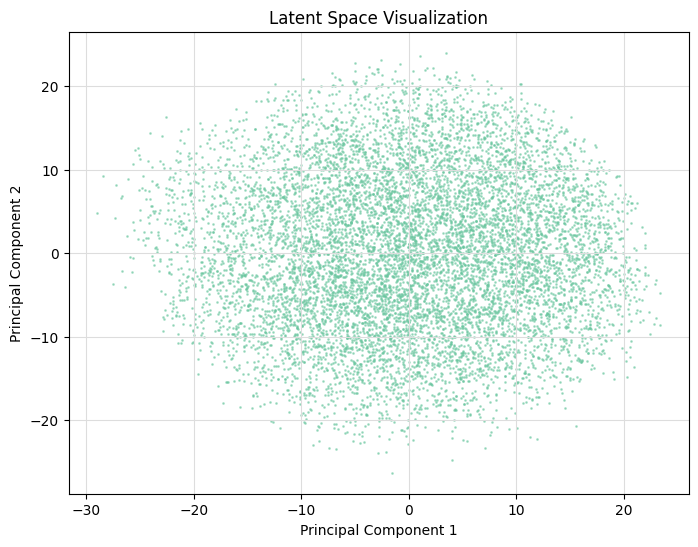

In [29]:
pca = PCA(n_components=2)
latent_space = pca.fit_transform(mu_flattened)

plt.figure(figsize=(8, 6))
plt.scatter(latent_space[:, 0], latent_space[:, 1], alpha=0.5, s=1)
plt.title('Latent Space Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()